In [33]:
import sys
sys.path.append('../')
from matplotlib import pyplot as plt

import pyreadr
import numpy as np
import pandas as pd
import copy
from scipy.optimize import fmin_slsqp
from sklearn.metrics import mean_squared_error

from utils.synth import *
from utils.competitors import *

In [34]:
START_TIME = 1970
INTERVENTION_TIME = 1989
STOP_TIME = 2001

'smoking.rda' data taken from https://github.com/johnson-shuffle/mixtape/tree/master/data

'prop99.csv' taken from https://github.com/jehangiramjad/tslib/tree/master/tests/testdata

In [35]:
# df_outcome_raw = pd.read_csv('Data/prop99.csv')
# df_outcome_raw = df_outcome_raw[df_outcome_raw['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
# df_outcome = pd.DataFrame(df_outcome_raw.pivot_table(values='Data_Value', index='LocationDesc', columns=['Year']).to_records())

# rda_predictors = pyreadr.read_r('Data/smoking.rda')
# df_predictors = pd.DataFrame(list(rda_predictors.values())[0])

In [36]:
# print(f'In the original dataset there are {df_outcome.LocationDesc.unique().shape[0]} states')
# # Section 3.2 in the paper
# bad_states = ['Massachusetts', 'Arizona', 'Oregon', 'Florida', 'Alaska', 'Hawaii', 'Maryland', 
#               'Michigan', 'New Jersey', 'New York', 'Washington', 'District of Columbia']

# df_outcome.drop(df_outcome[df_outcome['LocationDesc'].isin(bad_states)].index, inplace=True)
# ca_id = df_outcome[df_outcome['LocationDesc'] == 'California'].index.item()
# df_outcome = df_outcome.reset_index()
# df_outcome = df_outcome.rename(columns={'index': 'org_index'})
# print(f'After filtering out some states, we are left with {df_outcome.LocationDesc.unique().shape[0]} states (including California):')
# df_outcome.head()

In [37]:
# df_outcome_ca = df_outcome.loc[df_outcome['LocationDesc'] == 'California', :]
# df_outcome_control = df_outcome.loc[df_outcome['LocationDesc'] != 'California', :]

# ca_outcomes_pre = df_outcome_ca.loc[:,[str(i) for i in list(range(START_TIME, INTERVENTION_TIME))]].values.reshape(-1,1)
# control_outcomes_pre = df_outcome_control.loc[:,[str(i) for i in list(range(START_TIME, INTERVENTION_TIME))]].values.transpose()

# ca_outcomes_post = df_outcome_ca.loc[:,[str(i) for i in list(range(INTERVENTION_TIME, STOP_TIME))]].values.reshape(-1,1)
# control_outcomes_post = df_outcome_control.loc[:,[str(i) for i in list(range(INTERVENTION_TIME, STOP_TIME))]].values.transpose()

# Z0 = control_outcomes_pre
# Z1 = ca_outcomes_pre
# Y0 = control_outcomes_post
# Y1 = ca_outcomes_post

In [38]:
df = pd.read_stata('synth_smoking.dta')

# deal with predictors
predictors_avg_df = df[(df['year'] >= 1980) & (df['year'] <= 1988)].groupby('state').mean()
predictors_avg_df.drop(columns='year', inplace=True)  # Drop the 'year' column after averaging
predictors_avg_df = predictors_avg_df.drop(columns='cigsale')
beer_avg = df[(df['year'] >= 1984) & (df['year'] <= 1988)].groupby('state')['beer'].mean()
predictors_avg_df['beer'] = beer_avg
cigsale1975 = df[df['year'] == 1975].set_index('state')['cigsale']
cigsale1980 = df[df['year'] == 1980].set_index('state')['cigsale']
cigsale1985 = df[df['year'] == 1985].set_index('state')['cigsale']
# Rename the series for clarity when adding them to the DataFrame
cigsale1975.name = 'cigsale1975'
cigsale1980.name = 'cigsale1980'
cigsale1985.name = 'cigsale1985'
# Add these series to the predictors DataFrame
predictors_avg_df = predictors_avg_df.join(cigsale1975)
predictors_avg_df = predictors_avg_df.join(cigsale1980)
predictors_avg_df = predictors_avg_df.join(cigsale1985)
predictors_avg_df = predictors_avg_df.T  # Transpose if your predictors are currently in rows
california_predictors_df = predictors_avg_df[['California']]
non_california_predictors_df = predictors_avg_df.drop(columns='California')

# deal with responses
response_df = df.pivot(index='year', columns='state', values='cigsale')
california_response_df = response_df[['California']]
non_california_response_df = response_df.drop(columns='California')
california_pre_1988_df = california_response_df[california_response_df.index <= 1988]
california_post_1988_df = california_response_df[california_response_df.index > 1988]
non_california_pre_1988_df = non_california_response_df[non_california_response_df.index <= 1988]
non_california_post_1988_df = non_california_response_df[non_california_response_df.index > 1988]

/tmp/ipykernel_3951404/3153517033.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predictors_avg_df = df[(df['year'] >= 1980) & (df['year'] <= 1988)].groupby('state').mean()
/tmp/ipykernel_3951404/3153517033.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  beer_avg = df[(df['year'] >= 1984) & (df['year'] <= 1988)].groupby('state')['beer'].mean()


In [39]:
X0 = non_california_predictors_df
X1 = california_predictors_df
Z0 = non_california_pre_1988_df
Z1 = california_pre_1988_df
Y0 = non_california_post_1988_df
Y1 = california_post_1988_df

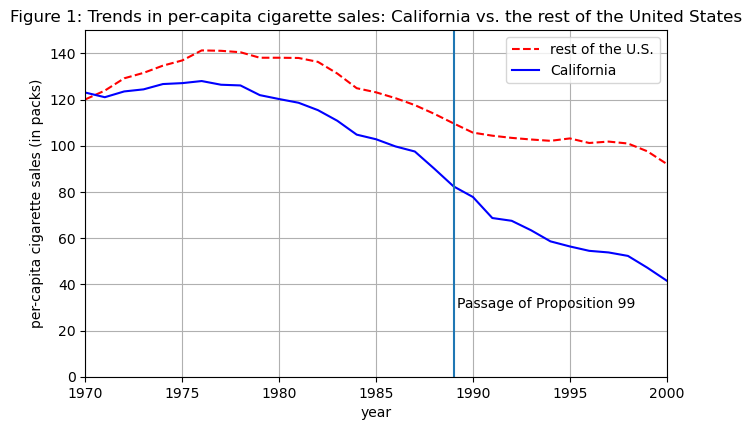

In [40]:
mean_outcomes = np.vstack([Z0, Y0]).mean(axis=1)
CA_outcomes = np.vstack([Z1, Y1]).flatten()
fig = plt.figure(figsize=(7.5,4.5))
plt.plot(range(START_TIME,STOP_TIME),mean_outcomes, 'r--', label="rest of the U.S.");
plt.plot(range(START_TIME,STOP_TIME),CA_outcomes, 'b-', label="California");

plt.ylabel('per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.title("Figure 1: Trends in per-capita cigarette sales: California vs. the rest of the United States")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME+0.2, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 150])
plt.grid()
plt.show()
# fig.savefig("name", dpi=300)

In [41]:
# def extract_predictor_vec(state):
#     df_outcome_state = df_outcome[df_outcome['LocationDesc'] == state]
#     cigsale88_predictor = df_outcome_state['1988'].item()
#     cigsale80_predictor = df_outcome_state['1980'].item()
#     cigsale75_predictor = df_outcome_state['1975'].item()
#     # cigsale71_predictor = df_outcome_state['1971'].item()
    
#     state_id_predictors_df = df_outcome[df_outcome['LocationDesc'] == 'California'].index.item() + 1
#     df_predictors_state = df_predictors[df_predictors['state'] == state_id_predictors_df]
#     beer_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1984) & (df_predictors_state['year'] < INTERVENTION_TIME), 'beer'].mean()
#     age15to24_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'age15to24'].mean()*100  # Should I turn multiply by 100? In table 1 it looks like it
#     retprice_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'retprice'].mean()
#     lnincome_predictor = df_predictors_state.loc[(df_predictors_state['year'] >= 1980) & (df_predictors_state['year'] < INTERVENTION_TIME), 'lnincome'].mean()
    
#     return np.array([lnincome_predictor, age15to24_predictor, retprice_predictor, beer_predictor,  
#                      cigsale88_predictor, cigsale80_predictor, cigsale75_predictor]).reshape(-1,1)

In [42]:
# control_predictors = []
# for state in df_outcome['LocationDesc'].unique():
#     state_predictor_vec = extract_predictor_vec(state)
#     if state == 'California':
#         ca_predictors = state_predictor_vec
#     else:
#         control_predictors += [state_predictor_vec]

# control_predictors = np.hstack(control_predictors)

# X0 = control_predictors
# X1 = ca_predictors

In [43]:
## select lambda
# n0 = X0.shape[1]
# lam_list = np.arange(0, 1, 0.02) # Lambda value
# # lam_list = [0.1]
# sspe_list = np.zeros(len(lam_list))
# for idx, lam in enumerate(lam_list):
#     W0 = np.zeros((n0-1, n0))
#     tau = np.zeros(n0)
#     for i in range(n0):
#         X_i = X0.T[i:(i+1),:]  # Example X_i vector
#         # Define the variable W_i (n_0 by 1 vector)
#         Xnm1 = np.delete(X0.T, i, axis=0)
#         W_i = solve_column(Xnm1, X_i, n0-1, lam, 'L-infty')
#         W0[:,i] = W_i
#         Ymn1 = np.delete(Y0.T, i, axis=0)
#         tau[i] = np.mean(Y0.T[i,:] - W0[:,i] @ Ymn1)
#     sspe_list[idx] = np.sum(np.square(tau))
#     # print(idx)
# lam = lam_list[np.argmin(sspe_list)]
# lam = loo_lambda_parallel(Y0.T, X0.T, start=-5, end=1, n_lam=50, norm='L-infty', verbose=False)
# print(lam)

In [44]:
Y1_pre = Z1.to_numpy().astype('float64')
Y0_pre = Z0.to_numpy().astype('float64')
Y1_post = Y1.to_numpy().astype('float64')
Y0_post = Y0.to_numpy().astype('float64')

In [45]:
W = sc(Y1_pre, Y0_pre)

In [47]:
print((X1.T.to_numpy().flatten() - X0.to_numpy() @ W) @ (X1.T.to_numpy().flatten() - X0.to_numpy() @ W).T)

2.0103112367837803


In [48]:
# import cplex
# from cplex.exceptions import CplexError
# # P = (X0.T @ X0 / 2).to_numpy()
# # q = (-X0.T @ X1).to_numpy()
# n = H.shape[1]
# # Initialize CPLEX problem
# prob = cplex.Cplex()
# prob.objective.set_sense(prob.objective.sense.minimize)

# # Define variable names
# variable_names = ["x" + str(i) for i in range(n)]

# # Add variables with bounds [0, 1]
# prob.variables.add(names=variable_names, lb=[0.0] * n, ub=[1.0] * n)

# # Set quadratic part of the objective function
# for i in range(n):
#     for j in range(n):
#         if H[i][j] != 0:
#             prob.objective.set_quadratic_coefficients(i, j, float(H[i, j]))

# # Set linear part of the objective function
# for i in range(n):
#     prob.objective.set_linear(variable_names[i], float(c[i]))

# # Add constraint: sum(x) = 1
# row = [list(range(n)), [1.0] * n]
# prob.linear_constraints.add(lin_expr=[row], senses=["E"], rhs=[1.0])

# # Solve the problem
# prob.solve()

# # Output the solution
# print("Solution status:", prob.solution.get_status())
# print("Solution value  :", prob.solution.get_objective_value())
# print("Solution vector :", prob.solution.get_values())

# # print(exc)

In [49]:
# W = np.array(prob.solution.get_values())
# print((X1.T.to_numpy().flatten() - X0.to_numpy() @ W) @ (X1.T.to_numpy().flatten() - X0.to_numpy() @ W).T)

In [50]:
a = pd.DataFrame({"State": non_california_response_df.columns.values, "Weight": W})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
a

,State,Weight
0,Alabama,-0.00000
1,Arkansas,-0.00000
2,Colorado,0.01481
3,Connecticut,0.10909
4,Delaware,-0.00000
5,Georgia,-0.00000
6,Idaho,-0.00000
7,Illinois,0.00000
8,Indiana,-0.00000
9,Iowa,-0.00000


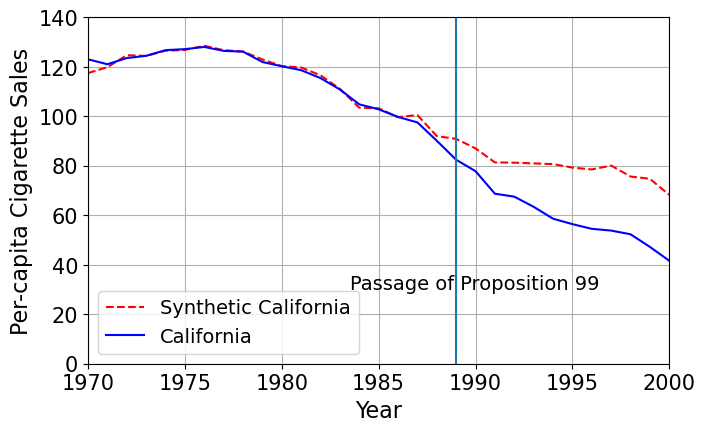

In [56]:
SC_outcomes = np.vstack([Z0, Y0]).dot(W)
CA_outcomes = np.vstack([Z1, Y1]).flatten()
fig = plt.figure(figsize=(7.5,4.5)) 

plt.plot(range(START_TIME,STOP_TIME),SC_outcomes, 'r--', label="Synthetic California");
plt.plot(range(START_TIME,STOP_TIME),CA_outcomes, 'b-', label="California");

plt.ylabel('Per-capita Cigarette Sales', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.legend(loc='lower left', fontsize=14)
# plt.title("Figure 2: Trends in per-capita cigarette sales: California vs. synthetic California")
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME-5.5, y=30, s='Passage of Proposition 99', fontsize=14)
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([0, 140])
plt.grid()
plt.xticks(fontsize=15)  
plt.yticks(fontsize=15)  
plt.show()
# fig.savefig("prop99_figure2", dpi=300)

#### Table 1

In [52]:
mean_predictors = X0.mean(axis=1).to_frame()
print("Table 1: Cigarette sales predictor means \n")
display(pd.DataFrame(np.hstack([X1, X0.dot(W).to_frame(), mean_predictors]), 
             columns=['Real California', 'Synthetic California', 'Average of 38 Controls']))

Table 1: Cigarette sales predictor means 



,Real California,Synthetic California,Average of 38 Controls
0,10.07656,9.84171,9.82920
1,24.28000,23.51837,23.65526
2,0.17353,0.17383,0.17251
3,89.42222,90.48016,87.26608
4,127.10000,126.77379,136.93159
5,120.20000,120.23364,138.08946
6,102.80000,103.18511,123.11580


#### Table 2: Top 5 donors

In [53]:
list(non_california_response_df.columns.values[np.flip(W.argsort())][:5])
# In the paper: Colorado, Connecticut, Montana, Nevada, Utah

['Utah', 'Montana', 'Nevada', 'Connecticut', 'New Hampshire']

#### Figure 3

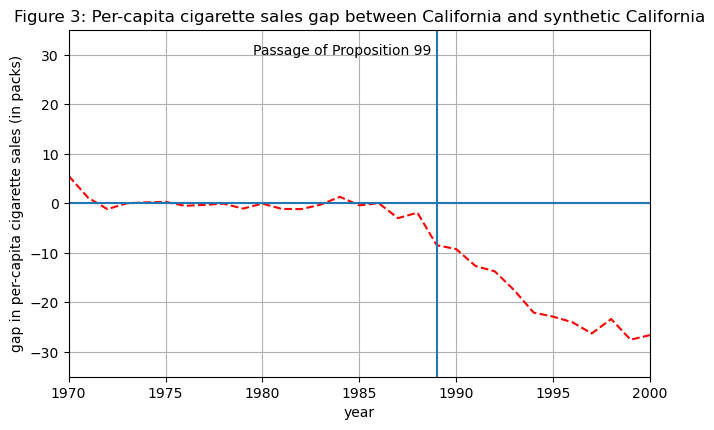

In [54]:
Gap_outcome = np.vstack([Z1, Y1]).flatten() - np.vstack([Z0, Y0]).dot(W)
fig = plt.figure(figsize=(7.5,4.5)) 

plt.plot(range(START_TIME,STOP_TIME),Gap_outcome, 'r--');
plt.ylabel('gap in per-capita cigarette sales (in packs)')
plt.xlabel('year')
plt.title("Figure 3: Per-capita cigarette sales gap between California and synthetic California")
plt.axhline(0)
plt.axvline(INTERVENTION_TIME)
plt.text(x=INTERVENTION_TIME-9.5, y=30, s='Passage of Proposition 99')
plt.xlim([START_TIME, STOP_TIME-1])
plt.ylim([-35, 35])
plt.grid()
plt.show()
# fig.savefig("prop99_figure3", dpi=300)